In [1]:

import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean, get_MOI, get_pendulum_invariance, get_SHM_invariance, get_damped_pendulum_invariance, get_damped_SHM_invariance
from invariance_functions import degree_of_freedom, get_GPR_model, get_SHM_data, get_pendulum_data, get_damped_pendulum_data, get_damped_SHM_data, get_grid_of_points_1D, evaluate_model_future, evaluate_model_grid, SHM_dynamics, pendulum_dynamics, damped_SHM_dynamics, damped_pendulum_dynamics
from parameterised_invariance_kernels import get_polynomial_invariance, get_damped_polynomial_invariance
from damped_invariance_kernel import SHMEpsilonMean, PendulumEpsilonMean, PolynomialEpsilonMean
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

In [2]:

class PendulumLatentInvariance(gpflow.kernels.Kernel):
    def __init__(self, invariance_range, invar_density, jitter_size):
        super().__init__(active_dims=[0, 1])
        self.jitter = jitter_size
        self.Ka = gpflow.kernels.RBF(variance=1, lengthscales=[1,1]) 
        self.Kv = gpflow.kernels.RBF(variance=1, lengthscales=[1,1]) 
        self.Kz = gpflow.kernels.RBF(variance=1, lengthscales=[1,1]) 

        invariance_xs = tf.linspace(-invariance_range,invariance_range,invar_density)
        invariance_vs = tf.linspace(-invariance_range,invariance_range,invar_density)
        invariance_xx, invariance_vv = tf.meshgrid(invariance_xs, invariance_vs)
        self.invar_grids = tf.stack([tf.reshape(invariance_xx,[-1]), tf.reshape(invariance_vv,[-1])], axis=1)

        self.x_g_squared = tf.tensordot(tf.math.sin(self.invar_grids[:,0,None]),tf.math.sin(self.invar_grids[None,:,0]),1)
        self.x_g_dot_squared = tf.tensordot(self.invar_grids[:,1,None],self.invar_grids[None,:,1],1)

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        n = X.shape[0]
        m = X2.shape[0]

        zeros_nn =tf.zeros((n,n), dtype=tf.float64)
        zeros_nm =tf.zeros((n,m), dtype=tf.float64)
        zeros_mm =tf.zeros((m,m), dtype=tf.float64)
        
        Ka_X1X1  = self.Ka(X) 
        Kv_X1X1  = self.Kv(X) 
        Kz_X1X1  = self.Kz(X) 
        K_X1X1   = tf.concat([tf.concat([Ka_X1X1,zeros_nn, zeros_nn],1),tf.concat([zeros_nn,Kv_X1X1,zeros_nn],1),tf.concat([zeros_nn,zeros_nn, Kz_X1X1],1)],0)

        Ka_X1X2  = self.Ka(X, X2) 
        Kv_X1X2  = self.Kv(X, X2) 
        Kz_X1X2  = self.Kz(X, X2) 
        K_X1X2   = tf.concat([tf.concat([Ka_X1X2,zeros_nm, zeros_nm],1),tf.concat([zeros_nm, Kv_X1X2, zeros_nm],1),tf.concat([zeros_nm, zeros_nm, Kz_X1X2],1)],0)
        
        K_X2X1   = tf.transpose(K_X1X2)
        
        Ka_X2X2  = self.Ka(X2) 
        Kv_X2X2  = self.Kv(X2) 
        Kz_X2X2  = self.Kz(X2) 
        K_X2X2   = tf.concat([tf.concat([Ka_X2X2,zeros_mm, zeros_mm],1),tf.concat([zeros_mm,Kv_X2X2, zeros_mm],1),tf.concat([zeros_mm, zeros_mm, Kz_X2X2],1)],0)
        
        Ka_X1Xg  = self.Ka(X, self.invar_grids) 
        Kv_X1Xg  = self.Kv(X, self.invar_grids) 
        Kz_X1Xg  = self.Kz(X, self.invar_grids) 
        K_X1Xg = tf.concat([Ka_X1Xg, Kv_X1Xg, Kz_X1Xg],0)

        Ka_X2Xg =  self.Ka(X2, self.invar_grids) 
        Kv_X2Xg =  self.Kv(X2, self.invar_grids)
        Kz_X2Xg  = self.Kz(X2, self.invar_grids) 
        K_X2Xg = tf.concat([Ka_X2Xg, Kv_X2Xg, Kz_X2Xg],0)

        Ka_XgXg = self.Ka(self.invar_grids) 
        Kv_XgXg = self.Kv(self.invar_grids) 
        Kz_XgXg = self.Kz(self.invar_grids) 
        
        x_g_1 = tf.ones([n, 1], dtype=tf.float64) * tf.math.sin(self.invar_grids[:,0])
        x_g_dot_1 = tf.ones([n, 1], dtype=tf.float64) * self.invar_grids[:,1]
        z_g_1 = tf.ones([n, x_g_1.shape[1]], dtype=tf.float64) 
        x_g_1_stacked = tf.concat([x_g_dot_1, x_g_1, z_g_1],0)
        
        x_g_2 = tf.ones([m, 1], dtype=tf.float64) * tf.math.sin(self.invar_grids[:,0])
        x_g_dot_2 = tf.ones([m, 1], dtype=tf.float64) * self.invar_grids[:,1]
        z_g_2 = tf.ones([m, x_g_2.shape[1]], dtype=tf.float64) 
        x_g_2_stacked = tf.concat([x_g_dot_2, x_g_2, z_g_2],0)

        
        A = tf.concat([tf.concat([K_X1X1, K_X1X2],1),tf.concat([K_X2X1, K_X2X2],1)],0) 
        B1 = tf.multiply(K_X1Xg, x_g_1_stacked)
        B2 = tf.multiply(K_X2Xg, x_g_2_stacked)
        B = tf.concat([B1, B2], 0)
        C = tf.transpose(B)
        D = tf.multiply(self.x_g_dot_squared, Ka_XgXg) + tf.multiply(self.x_g_squared, Kv_XgXg) + Kz_XgXg 
        D += self.jitter*tf.eye(D.shape[0], dtype=tf.float64)
        return (A-tf.tensordot(tf.tensordot(B, tf.linalg.inv(D), 1), C, 1))[:2*n, 3*n:(3*n+2*m)]

    def K_diag(self, X):
        n = X.shape[0]
        zeros_nn =tf.zeros((n,n), dtype=tf.float64)
        
        Ka_X  = self.Ka(X) 
        Kv_X  = self.Kv(X) 
        Kz_X  = self.Kz(X)
        K_X   = tf.concat([tf.concat([Ka_X,zeros_nn, zeros_nn],1),tf.concat([zeros_nn,Kv_X, zeros_nn],1),tf.concat([zeros_nn, zeros_nn, Kz_X],1)],0)
        
        Ka_Xg  = self.Ka(X, self.invar_grids) 
        Kv_Xg  = self.Kv(X, self.invar_grids) 
        Kz_Xg  = self.Kz(X, self.invar_grids) 
        K_Xg = tf.concat([Ka_Xg, Kv_Xg, Kz_Xg],0)

        Ka_XgXg = self.Ka(self.invar_grids) 
        Kv_XgXg = self.Kv(self.invar_grids) 
        Kz_XgXg = self.Kz(self.invar_grids) 
        
        x_g = tf.ones([n, 1], dtype=tf.float64) * tf.math.sin(self.invar_grids[:,0])
        x_g_dot = tf.ones([n, 1], dtype=tf.float64) * self.invar_grids[:,1]
        z_g = tf.ones([n, x_g.shape[1]],dtype=tf.float64)
        x_g_stacked = tf.concat([x_g_dot, x_g, z_g],0)
        
        A = K_X
        B = tf.multiply(K_Xg, x_g_stacked)
        C = tf.transpose(B)
        D = tf.multiply(self.x_g_dot_squared, Ka_XgXg) + tf.multiply(self.x_g_squared, Kv_XgXg) + Kz_XgXg
        D += self.jitter*tf.eye(D.shape[0], dtype=tf.float64)
        
        return tf.linalg.tensor_diag_part((A-tf.tensordot(tf.tensordot(B, tf.linalg.inv(D),1), C, 1))[:2*n,:2*n])

In [3]:

class PolynomialLatentInvariance(gpflow.kernels.Kernel):
    def __init__(self, invariance_range, invar_density, jitter_size, poly_f_d, poly_g_d):
        super().__init__(active_dims=[0,1])
        self.poly_f_d = poly_f_d
        self.poly_g_d = poly_g_d
        self.prior_variance = 1#gpflow.Parameter(0.1, transform=positive())#tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(1.)))
        self.f_poly = gpflow.Parameter(tf.Variable(1e-3*np.ones((self.poly_f_d,1)), dtype=tf.float64), transform =tfp.bijectors.Sigmoid(to_default_float(-1.), to_default_float(1.)), prior=tfp.distributions.Laplace(to_default_float(0),to_default_float(self.prior_variance)), name="f_poly")
        self.g_poly = gpflow.Parameter(tf.Variable(1e-3*np.ones((self.poly_g_d,1)), dtype=tf.float64), transform =tfp.bijectors.Sigmoid(to_default_float(-1.), to_default_float(1.)), prior=tfp.distributions.Laplace(to_default_float(0),to_default_float(self.prior_variance)), name="g_poly")

        self.jitter =jitter_size
        self.Ka = gpflow.kernels.RBF(variance=1, lengthscales=[1,1]) 
        self.Kv = gpflow.kernels.RBF(variance=1, lengthscales=[1,1]) 
        self.Kz = gpflow.kernels.RBF(variance=1, lengthscales=[1,1]) 
        invariance_xs = tf.linspace(-invariance_range,invariance_range,invar_density)
        invariance_vs = tf.linspace(-invariance_range,invariance_range,invar_density)
        invariance_xx, invariance_vv = tf.meshgrid(invariance_xs, invariance_vs)
        self.invar_grids = tf.stack([tf.reshape(invariance_xx,[-1]), tf.reshape(invariance_vv,[-1])], axis=1)

    def inv_f(self, X):
        return tf.linalg.matmul(tf.math.pow(X, list(range(self.poly_f_d))), self.f_poly)
    def inv_g(self, X):
        return tf.linalg.matmul(tf.math.pow(X, list(range(self.poly_g_d))), self.g_poly)

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        n = X.shape[0]
        m = X2.shape[0]

        zeros_nn =tf.zeros((n,n), dtype=tf.float64)
        zeros_nm =tf.zeros((n,m), dtype=tf.float64)
        zeros_mm =tf.zeros((m,m), dtype=tf.float64)
        
        Ka_X1X1  = self.Ka(X) 
        Kv_X1X1  = self.Kv(X) 
        Kz_X1X1  = self.Kz(X) 
        K_X1X1   = tf.concat([tf.concat([Ka_X1X1,zeros_nn, zeros_nn],1),tf.concat([zeros_nn,Kv_X1X1,zeros_nn],1),tf.concat([zeros_nn,zeros_nn, Kz_X1X1],1)],0)

        Ka_X1X2  = self.Ka(X, X2) 
        Kv_X1X2  = self.Kv(X, X2) 
        Kz_X1X2  = self.Kz(X, X2) 
        K_X1X2   = tf.concat([tf.concat([Ka_X1X2,zeros_nm, zeros_nm],1),tf.concat([zeros_nm, Kv_X1X2, zeros_nm],1),tf.concat([zeros_nm, zeros_nm, Kz_X1X2],1)],0)
        
        K_X2X1   = tf.transpose(K_X1X2)
        
        Ka_X2X2  = self.Ka(X2) 
        Kv_X2X2  = self.Kv(X2) 
        Kz_X2X2  = self.Kz(X2) 
        K_X2X2   = tf.concat([tf.concat([Ka_X2X2,zeros_mm, zeros_mm],1),tf.concat([zeros_mm,Kv_X2X2, zeros_mm],1),tf.concat([zeros_mm, zeros_mm, Kz_X2X2],1)],0)
        
        Ka_X1Xg  = self.Ka(X, self.invar_grids) 
        Kv_X1Xg  = self.Kv(X, self.invar_grids) 
        Kz_X1Xg  = self.Kz(X, self.invar_grids) 
        K_X1Xg = tf.concat([Ka_X1Xg, Kv_X1Xg, Kz_X1Xg],0)

        Ka_X2Xg =  self.Ka(X2, self.invar_grids) 
        Kv_X2Xg =  self.Kv(X2, self.invar_grids)
        Kz_X2Xg  = self.Kz(X2, self.invar_grids) 
        K_X2Xg = tf.concat([Ka_X2Xg, Kv_X2Xg, Kz_X2Xg],0)

        Ka_XgXg = self.Ka(self.invar_grids) 
        Kv_XgXg = self.Kv(self.invar_grids) 
        Kz_XgXg = self.Kz(self.invar_grids) 
        
        x_g_1 = tf.ones([n, 1], dtype=tf.float64) * tf.squeeze(self.inv_g(self.invar_grids[:,0, None]))
        x_g_dot_1 = tf.ones([n, 1], dtype=tf.float64) * tf.squeeze(self.inv_f(self.invar_grids[:,1, None]))
        z_g_1 = tf.ones([n, x_g_1.shape[1]], dtype=tf.float64) 
        x_g_1_stacked = tf.concat([x_g_dot_1, x_g_1, z_g_1],0)
        
        x_g_2 = tf.ones([m, 1], dtype=tf.float64) * tf.squeeze(self.inv_g(self.invar_grids[:,0, None]))
        x_g_dot_2 = tf.ones([m, 1], dtype=tf.float64) * tf.squeeze(self.inv_f(self.invar_grids[:,1, None]))
        z_g_2 = tf.ones([m, x_g_2.shape[1]], dtype=tf.float64) 
        x_g_2_stacked = tf.concat([x_g_dot_2, x_g_2, z_g_2],0)

        x_g_squared = tf.tensordot(self.inv_g(self.invar_grids[:,0,None]),tf.transpose(self.inv_g(self.invar_grids[:,0, None])),1)
        x_g_dot_squared = tf.tensordot(self.inv_f(self.invar_grids[:,1,None]),tf.transpose(self.inv_f(self.invar_grids[:,1, None])),1)
        
        A = tf.concat([tf.concat([K_X1X1, K_X1X2],1),tf.concat([K_X2X1, K_X2X2],1)],0) 
        B1 = tf.multiply(K_X1Xg, x_g_1_stacked)
        B2 = tf.multiply(K_X2Xg, x_g_2_stacked)
        B = tf.concat([B1, B2], 0)
        C = tf.transpose(B)

        D = tf.multiply(x_g_dot_squared, Ka_XgXg) + tf.multiply(x_g_squared, Kv_XgXg) + Kz_XgXg 
        D += self.jitter*tf.eye(D.shape[0], dtype=tf.float64)
        return (A-tf.tensordot(tf.tensordot(B, tf.linalg.inv(D), 1), C, 1))[:2*n, 3*n:(3*n+2*m)]

    def K_diag(self, X):
        n = X.shape[0]
        zeros_nn =tf.zeros((n,n), dtype=tf.float64)
        
        Ka_X  = self.Ka(X) 
        Kv_X  = self.Kv(X) 
        Kz_X  = self.Kz(X)
        K_X   = tf.concat([tf.concat([Ka_X,zeros_nn, zeros_nn],1),tf.concat([zeros_nn,Kv_X, zeros_nn],1),tf.concat([zeros_nn, zeros_nn, Kz_X],1)],0)
        
        Ka_Xg  = self.Ka(X, self.invar_grids) 
        Kv_Xg  = self.Kv(X, self.invar_grids) 
        Kz_Xg  = self.Kz(X, self.invar_grids) 
        K_Xg = tf.concat([Ka_Xg, Kv_Xg, Kz_Xg],0)

        Ka_XgXg = self.Ka(self.invar_grids) 
        Kv_XgXg = self.Kv(self.invar_grids) 
        Kz_XgXg = self.Kz(self.invar_grids) 
        
        x_g = tf.ones([n, 1], dtype=tf.float64) * tf.squeeze(self.inv_g(self.invar_grids[:,0, None]))
        x_g_dot = tf.ones([n, 1], dtype=tf.float64) * tf.squeeze(self.inv_f(self.invar_grids[:,1, None]))
        z_g = tf.ones([n, x_g.shape[1]],dtype=tf.float64)
        x_g_stacked = tf.concat([x_g_dot, x_g, z_g],0)
        
        x_g_squared = tf.tensordot(self.inv_g(self.invar_grids[:,0,None]),tf.transpose(self.inv_g(self.invar_grids[:,0, None])),1)
        x_g_dot_squared = tf.tensordot(self.inv_f(self.invar_grids[:,1,None]),tf.transpose(self.inv_f(self.invar_grids[:,1, None])),1)
        
        A = K_X
        B = tf.multiply(K_Xg, x_g_stacked)
        C = tf.transpose(B)
        D = tf.multiply(x_g_dot_squared, Ka_XgXg) + tf.multiply(x_g_squared, Kv_XgXg) + Kz_XgXg
        D += self.jitter*tf.eye(D.shape[0], dtype=tf.float64)
        
        return tf.linalg.tensor_diag_part((A-tf.tensordot(tf.tensordot(B, tf.linalg.inv(D),1), C, 1))[:2*n,:2*n])

In [4]:

def get_latent_polynomial_invariance(invar_range, invar_density, jitter_size, poly_f_d, poly_g_d):
    invariance_kernel = PolynomialLatentInvariance(invar_range, invar_density, jitter_size, poly_f_d, poly_g_d)
    invariance_kernel.Ka.variance = gpflow.Parameter(invariance_kernel.Ka.variance.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kv.variance = gpflow.Parameter(invariance_kernel.Kv.variance.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kz.variance = gpflow.Parameter(invariance_kernel.Kz.variance.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Ka.lengthscales = gpflow.Parameter(invariance_kernel.Ka.lengthscales.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kv.lengthscales = gpflow.Parameter(invariance_kernel.Kv.lengthscales.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kz.lengthscales = gpflow.Parameter(invariance_kernel.Kz.lengthscales.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    return invariance_kernel

def get_latent_pendulum_invariance(invar_range, invar_density, jitter_size):
    invariance_kernel = PendulumLatentInvariance(invar_range, invar_density, jitter_size)
    invariance_kernel.Ka.variance = gpflow.Parameter(invariance_kernel.Ka.variance.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kv.variance = gpflow.Parameter(invariance_kernel.Kv.variance.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kz.variance = gpflow.Parameter(invariance_kernel.Kz.variance.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Ka.lengthscales = gpflow.Parameter(invariance_kernel.Ka.lengthscales.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kv.lengthscales = gpflow.Parameter(invariance_kernel.Kv.lengthscales.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kz.lengthscales = gpflow.Parameter(invariance_kernel.Kz.lengthscales.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    return invariance_kernel

In [5]:
mean = ZeroMean(2)
time_step = 0.01
training_time = 0.1
testing_time = 3

max_x = (150)
max_v = (10)
n_train = 5
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position)
print(train_starting_velocity)
data = get_damped_pendulum_data(0.1, time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch

[  60.08296058  -47.67018755   87.11523463 -117.33106244 -136.32449558]
[-2.52958806 -3.91947354  1.20265406 -1.75506482  6.01341385]


In [9]:

moi = get_GPR_model(get_MOI(), mean, data, 500)
print("moi:"+format(moi.log_marginal_likelihood().numpy(),".2f"))
jitter = 1e-4
invar_density = 30
latex=""
kernel = get_latent_pendulum_invariance(np.radians(150), invar_density, jitter) #switch
known = get_GPR_model(kernel, mean, data, 500)
print("known: "+format(known.log_marginal_likelihood().numpy(),".2f"))
i = 0
for poly_f_d in [2]:
    for poly_g_d in [4]:
        kernel = get_latent_polynomial_invariance(np.radians(150), invar_density, jitter, poly_f_d, poly_g_d) #switch
        m = get_GPR_model(kernel, mean, data, 3000)
        print("learnt: "+format(m.log_marginal_likelihood().numpy(),".2f"))

moi:402.36
known: 430.32
learnt: 412.47


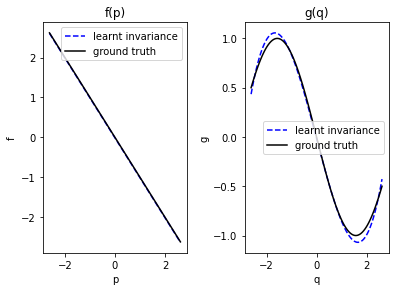

In [11]:

import matplotlib.pyplot as plt
from numpy.polynomial import polynomial
x = np.linspace(-np.radians(150),np.radians(150),100)
multiplier = -m.kernel.f_poly.numpy()[1]
f = polynomial.Polynomial(np.squeeze(kernel.f_poly.numpy()))
g = polynomial.Polynomial(np.squeeze(kernel.g_poly.numpy()))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, f(x)/multiplier, "--", color="blue", label='learnt invariance')
ax1.plot(x, -x, label='ground truth', color="black")
ax1.set_title("f(p)")
ax1.set_xlabel("p")
ax1.set_ylabel("f")
ax1.legend()
ax2.set_title("g(q)")
ax2.plot(x, g(x)/multiplier, "--", color="blue",label='learnt invariance')
ax2.plot(x, -np.sin(x), color="black", label='ground truth')
ax2.legend()
ax2.set_xlabel("q")
ax2.set_ylabel("g")
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
#plt.savefig("figures/shm_learnt.pdf")



In [12]:
m.kernel

name,class,transform,prior,trainable,shape,dtype,value
PolynomialLatentInvariance.f_poly,Parameter,Sigmoid,Laplace,True,"(2, 1)",float64,[[0.0001628 ] [0.01336924]]
PolynomialLatentInvariance.g_poly,Parameter,Sigmoid,Laplace,True,"(4, 1)",float64,[[1.75938672e-04...
PolynomialLatentInvariance.Ka.variance,Parameter,Sigmoid,,True,(),float64,10.0
PolynomialLatentInvariance.Ka.lengthscales,Parameter,Sigmoid,,True,"(2,)",float64,[ 2.56207105 10. ]
PolynomialLatentInvariance.Kv.variance,Parameter,Sigmoid,,True,(),float64,9.190040196770955
PolynomialLatentInvariance.Kv.lengthscales,Parameter,Sigmoid,,True,"(2,)",float64,[10. 5.16858206]
PolynomialLatentInvariance.Kz.variance,Parameter,Sigmoid,,True,(),float64,0.001
PolynomialLatentInvariance.Kz.lengthscales,Parameter,Sigmoid,,True,"(2,)",float64,[9.990435e+00 1.000000e-03]


In [13]:
known

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Ka.variance,Parameter,Sigmoid,,True,(),float64,9.999996808162264
GPR.kernel.Ka.lengthscales,Parameter,Sigmoid,,True,"(2,)",float64,[2.12455228 3.03976511]
GPR.kernel.Kv.variance,Parameter,Sigmoid,,True,(),float64,9.99998472059606
GPR.kernel.Kv.lengthscales,Parameter,Sigmoid,,True,"(2,)",float64,[10. 4.91565665]
GPR.kernel.Kz.variance,Parameter,Sigmoid,,True,(),float64,0.2468372044985027
GPR.kernel.Kz.lengthscales,Parameter,Sigmoid,,True,"(2,)",float64,[9.99999997 0.05315069]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0000000172253073e-06


In [15]:
eva_future_moi = []
eva_future_inv = []
eva_future_inv_p = []

dynamics = damped_pendulum_dynamics

lml_moi = moi.log_marginal_likelihood().numpy()
lml_inv = known.log_marginal_likelihood().numpy()
lml_inv_p = m.log_marginal_likelihood().numpy()

#grid_moi = (evaluate_model_grid(moi, grids, dynamics))
#grid_inv = (evaluate_model_grid(known, grids, dynamics))
#grid_inv_p = (evaluate_model_grid(m, grids, dynamics))
print(lml_moi)
print(lml_inv)
print(lml_inv_p)
def energy(X):
    return 0.5*tf.square(X[:,1])-np.cos(X[:,0])

for i in range(5):
    print(i)
    test_starting_position = np.radians(np.random.uniform(-max_x, max_x))
    test_starting_velocity = np.radians(np.random.uniform(-max_v, max_v))

#    print(test_starting_position)
#    print(test_starting_velocity)
    test_starting = (test_starting_position, test_starting_velocity)
    time_setting = (testing_time, time_step)

    evaluate_moi = evaluate_model_future(moi, test_starting, dynamics,time_setting, energy)
    eva_future_moi.append(evaluate_moi[0])
    print(evaluate_moi[0])

    evaluate_invariance =evaluate_model_future(known, test_starting, dynamics,time_setting, energy)
    eva_future_inv.append(evaluate_invariance[0])
    print(evaluate_invariance[0])

    evaluate_invariance_p =evaluate_model_future(m, test_starting, dynamics, time_setting, energy)#, (m.kernel.inv_f, m.kernel.inv_g), (lambda x: x, lambda x:np.sin(x)))
    eva_future_inv_p.append(evaluate_invariance_p[0])
    print(evaluate_invariance_p[0])


402.3628403403827
430.3205350415423
412.4744479477166
0
0.010115834873698323
0.009767138438018345
0.00990122985475182g
1
0.4700610521714873g
0.027124713580730233
0.02215278555260694g
2
0.14963579003715252g
0.03733521452397092g
0.014555156875517682
3
0.4305166717638401gg
0.037056816452091856
0.02119181987118322g
4
0.3405295234409464g
0.02434914467930442g
0.021328721999030114


In [16]:
print("Log Marginal Likelihood & " + format((lml_moi),".2f")+" & "+ format((lml_inv),".2f") + " & "+ format((lml_inv_p),".2f") +' \\\\')
print("MSE & "+ format((np.mean(eva_future_moi)),".4f")+" & "+format(np.mean(eva_future_inv),".4f")+" & "+format((np.mean(eva_future_inv_p)),".4f")+ ' \\\\')

Log Marginal Likelihood & 402.36 & 430.32 & 412.47 \\
MSE & 0.2802 & 0.0271 & 0.0178 \\


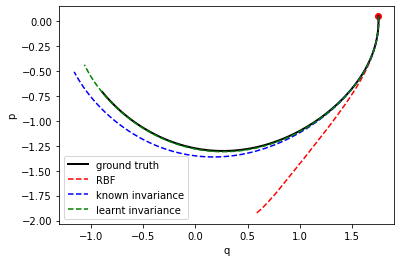

In [17]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="ground truth", color="black", linewidth=2)
plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="known invariance", color="blue")
plt.plot(evaluate_invariance_p[1][:,0],evaluate_invariance_p[1][:,1], "--", label="learnt invariance", color="green")
plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()
#plt.savefig("figures/shm_predicted.pdf")

Text(0, 0.5, 'E')

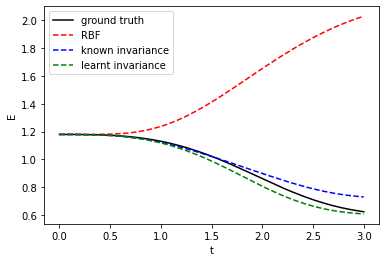

In [18]:

t = np.linspace(0, testing_time, int(testing_time/time_step))
plt.plot(t, tf.squeeze(evaluate_invariance[5])+1, label="ground truth", color="black")
plt.plot(t, tf.squeeze(evaluate_moi[6])+1, "--", label="RBF", color="red")
plt.plot(t, tf.squeeze(evaluate_invariance[6])+1,"--" ,  label="known invariance", color="blue")
plt.plot(t, tf.squeeze(evaluate_invariance_p[6])+1, "--",label="learnt invariance", color="green")
plt.legend()
plt.xlabel("t")
plt.ylabel("E")
#plt.savefig("figures/shm_energy.pdf")